  Written by: Anonymous author

  Last update: Sep, 2024

   # Using BRAID
   ## Modeling data
   To use BRAID, you first need to import the BRAIDModel and MainModel classes, for example by running:
   ```python
   from BRAID.MainModel import MainModel, BRAIDModelPrepareArgs
   from BRAID import BRAIDModel
   ```

   You can then use it to model data as:
   ```python
   idSys = BRAIDModel()
   methodCode = 'BRAID_Cz1HL64U' # Only Cz will be nonlinear, 1 Hidden layer with 64 Units.
   args = MainModelPrepareArgs(methodCode)
   idSys.fit(Y, Z, U=U, nx=6, n1=2, n3=None, n_pre=None, args_base=args)
   ```

   With the following arguments:
   - `Y`: Neural (e.g. Smoothed spike counts or LFP signal powers), Dimensions are: data x time.
  
   - `Z`: behavioral data (e.g. joint angles, hand position, etc), Dimensions are: data x time.

   - `U`: Input data (e.g. sesnory stimuli, electrical stimulation, etc), Dimensions are: data x time.

   - `nx`: the total dimension of the latent state in the model.

   - `n1`: the number of latent state dimensions that are going to be dedicated to behaviorally relevant neural dynamics.
  
   - `n3`: the number of latent state dimensions dedicated to behavior-specific dynamics. By default set to None to disable this iptional dynamics. (in effect only if "nx > n1 AND n3 not None").

   - `n_pre`: the number of latent state dimensions of the optional preprocessing model. By default set to None to avoid this preprocessing stage.

   - args: other arguments that specify training settings and the type of nonlinearity in each parameter within the model.

   A helper function called `BRAIDModelPrepareArgs` can be used to prepare the additional arguments `args` that are passed to `idSys.fit`. This function simply takes `methodCode` string as input and returns the relevant arguments to pass to `idSys.fit`. For example, in the above code `methodCode` is `'BRAID_Cz1HL64U'`. In this case, only the behavior readout parameter $C_z$ of the learned model will be nonlinear and all other parameters will be linear. You can inspect the output of `BRAIDModelPrepareArgs` to see how the architecture of each linear/nonlinear model parameter can be specified as an argument to `idSys.fit`.

  After running the above, the learned model will be stored in the `BRAIDModel.sId` object called `idSys.sId`.

   ## Using the model for dimension reduction, state estimation, neural self-prediction and behavior decoding
   For a learned BRAID model `idSys` you can use the `predict` method to extract the latent state and predict behavior and neural activity given any new neural data as:
   ```python
   zPred, yPred, xPred = idSys.predict(yTest, U=uYest)
   ```
   With the argument:
   - `yTest`: Neural activity `y` in the test data. Dimensions are: time x data dimension.

   - `uTest`: Input `y` in the test data. Dimensions are: time x data dimension.

   And with outputs (all dimensions are time x data dimension):
   - `zPred`: Prediction of behavior using past neural activity at each data point.

   - `yPred`: Prediction of neural activity using past neural activity and inputs at each data point.

   - `xPred`: The latent state extracted at each data point.

   We will next go through two complete examples of using BRAID in data.

# Example 1: Full BRAID example including preprocessing on simulated data with nonlinear behavior decoder Cz 
   In this example, we will use BRAID (including the behavior preprocessing stage) to model some simulated data and demonstrate its use case in that data.

   First, we import BRAID and a few other useful tools from BRAID and other libraries.

In [1]:
import logging
import os
import sys

sys.path.insert(0, os.path.join("..", ".."))
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), "..", ".."))

# Setting up logs
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import coloredlogs

coloredlogs.install(
    level=logging.INFO,
    fmt="%(asctime)s %(name)s [%(filename)s > %(lineno)s] %(levelname)s %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    logger=logger,
)

# Prepare plots
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches

matplotlib.rcParams["figure.facecolor"] = "w"
matplotlib.rcParams["axes.facecolor"] = "w"
matplotlib.rcParams.update(
    {"font.size": 16, "axes.titlesize": 14, "axes.labelsize": 14}
)

# Import BRAID tools
import BRAID
from BRAID.BRAIDModel import BRAIDModel, runPredict
from BRAID.MainModel import MainModel, MainModelPrepareArgs
from BRAID.tools.evaluation import computeEigIdError, evalPrediction, evaluateDecoding
from BRAID.tools.file_tools import pickle_load
from BRAID.tools.LSSM import LSSM
from BRAID.tools.SSM import SSM

# Set random seeds for exact reproducibility
seed = 42
import random

import numpy as np
import tensorflow as tf

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

   Let's start by loading data from an example model where only $C_z$ is nonlinear:
   
   An example simulated data with trigonometric behavioral mapping (nonlinear Cz) and the true underlying generative model are loaded from ./data/sample_data_CzNL_prep.p

In [2]:
data_dir = os.path.join(os.path.dirname(BRAID.__file__), "..", "..", "data")
fName1 = "sample_data_CzNL_prep.p"
sample_data_path1 = os.path.join(data_dir, fName1)

print("Loading example data from {}".format(sample_data_path1))
data1 = pickle_load(sample_data_path1)

maxN = int(2 * 1e4)  # Number of data points to use in this notebook
N = np.min((maxN, data1["x"].shape[0]))
x = data1["x"][:N, :] # get data
y = data1["y"][:N, :]
z = data1["z"][:N, :]
u = data1["u"][:N, :]
trueLSSM = LSSM(params=data1['csys']) 
trueModel_main = SSM(lssm=trueLSSM, params=data1['csys']) # Create the object containing the main true model corresponding to [X1, X2]^T
trueModel_beh = LSSM(params=data1['csys']['zErrSys']) # Create the object that contains the true model corresponding to X3 (behavior-specific dynamics)
nx = trueModel_main.state_dim  # Dimesnionality of the main model (true n1+n2)
n1 = len(trueModel_main.zDims)  # The number of encoded latent states in the simulated model that drive behavior (behaviorally relevant neural dynamics)

allYData, allZData, allUData = y, z, u

Loading example data from ..\..\BRAID\..\..\data\sample_data_CzNL_prep.p


   Let's separate the data into training and test segments.

In [3]:
# Separate data into training and test data:
testInds = np.arange(np.round(0.5 * allYData.shape[0]), dtype=int)
trainInds = np.arange(1 + testInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]
uTrain = allUData[trainInds, :]
uTest = allUData[testInds, :]

Now we normalize data before training:

In [4]:
# Normalize data (removing the mean is essential before training):
yMean, yStd = np.mean(yTrain,axis=0), np.std(yTrain,axis=0)
yTrainN, yTestN = (yTrain - yMean)/yStd, (yTest - yMean)/yStd

zMean, zStd = np.mean(zTrain,axis=0), np.std(zTrain,axis=0)
zTrainN, zTestN = (zTrain - zMean)/zStd, (zTest - zMean)/zStd

uMean, uStd = np.mean(uTrain,axis=0), np.std(uTrain,axis=0)
uTrainN, uTestN = (uTrain - uMean)/uStd, (uTest - uMean)/uStd

Training the model:

In [ ]:
# Fit BRAID model to data:

idSysF = BRAIDModel()

methodCode = 'BRAID_Cz1HL64U' # An BRAID Model with a nonlinear behavior decoder Cz, implemented as an MLP with 1 Hidden layer and 64 Units.
args = MainModelPrepareArgs(methodCode) # This function takes a method name as string and parses settings for fitting BRAID model. Please read the function for details.
args['epochs'] = 2500 # Default for this is 2500. Fitting will stop upon convergence or after at most the specified number of # epochs. 2500 as the max number of epochs is usually more than enough.

# Fitting BRAID Model with the ground truth dimensions. 
# Parameter n_pre defines the dimension of the preprocessing RNN (x0)
# Parameter n3 defines the number of behavior-specific states to be learned after stages 1 and 2 are done.
idSysF.fit(yTrainN.T, Z=zTrainN.T, U=uTrainN.T, nx=nx+trueModel_beh.state_dim, n1=n1, n3=trueModel_beh.state_dim, n_pre=nx, args_base=args)
idSysF.yMean, idSysF.yStd,  idSysF.zMean, idSysF.zStd,  idSysF.uMean, idSysF.uStd =  yMean, yStd,  zMean, zStd,  uMean, uStd # saving preprocessing info in model objects to use during inference in runPredict function
print('Training finished after {} epochs'.format(len(idSysF.sId.logs['model1']['history']['loss'])))

Inference on test data and calculating prediction performances:

In [6]:
# Inference:
# Predict behavior and neural activity, from past neural activity and inputs, using the learned model
print("Computing predictions for the learned model")
# This function takes test data (unnormalized). Normalization happens inside runPredict given the saved mean and std attributes
zTestPredF, yTestPredF, xTestPredF, _, _, _ = runPredict(idSysF, yTest, zTest, uTest, YType='cont', ZType='cont')
# runPredict function outputs are lists of length= #steps_ahead desired for inference which is taken from the field: idSysF.step_ahead
# Here we are only looking at 1-step-ahead predictions i.e., the lists only have one element:
zTestPredF, yTestPredF, xTestPredF = zTestPredF[0], yTestPredF[0], xTestPredF[0] 

# Compute CC of decoding and self-prediction
zCCNonLinF = evalPrediction(zTestN, zTestPredF, "CC")
yCCNonLinF = evalPrediction(yTestN, yTestPredF, "CC")

# Decode behavior and do neural self-prediction using the true model for comparison
print("Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)")
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal, _, _, _ = runPredict(trueModel_main, yTest, zTest, uTest, YType='cont', ZType='cont')
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal = zTestPredIdeal[0], yTestPredIdeal[0], xTestPredIdeal[0] 

zCCIdeal = evalPrediction(zTest, zTestPredIdeal, "CC")
yCCIdeal = evalPrediction(yTest, yTestPredIdeal, "CC")

print(
    f"Behavior decoding CC:\n  BRAID => {np.mean(zCCNonLinF):.3g}, Ideal using true model => {np.mean(zCCIdeal):.3g}"
)
print(
    f"Neural self-prediction CC:\n  BRAID => {np.mean(yCCNonLinF):.3g}, Ideal using true model => {np.mean(yCCIdeal):.3g}"
)

print('End of example 1!')

Computing predictions for the learned model
Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)


applying Cz: 100%|██████████| 10000/10000 [00:10<00:00, 918.78it/s]

Behavior decoding CC:
  BRAID => 0.9, Ideal using true model => 0.948
Neural self-prediction CC:
  BRAID => 0.86, Ideal using true model => 0.86
End of example 1!


## Example 2: BRAID forecasting example on simulated data with nonlinear behavior decoder 


In [7]:
# Load data
# An example simulated data with trigonometric behavioral mapping (nonlinear Cz)
# and the true underlying generative model are loaded from ./data/sample_data_CzNL.p
data_dir = os.path.join(os.path.dirname(BRAID.__file__), "..", "..", "data")
fName2 = "sample_data_CzNL.p"
sample_data_path2 = os.path.join(data_dir, fName2)

print("Loading example data from {}".format(sample_data_path2))
data2 = pickle_load(sample_data_path2)
# This data is from an example model from results shown in Fig. 2a-d, with nonlinearity only in the behavior readout parameter Cz.

maxN = int(2 * 1e4)  # Number of data points to use in this notebook
N = np.min((maxN, data2["x"].shape[0]))
x = data2["x"][:N, :]
y = data2["y"][:N, :]
z = data2["z"][:N, :]
u = data2["u"][:N, :]

trueLSSM = LSSM(params=data2['csys'])
trueModel_main = SSM(lssm=trueLSSM, params=data2['csys']) #data["csys"]  # The object that contains the true corresponding to [X1, X2]^T

trueLSSM = LSSM(params=data2['csys'])
trueModel = SSM(lssm=trueLSSM, params=data2['csys']) 
nx = trueModel.state_dim  # Total number of latent states in the simulated model
n1 = len(trueModel.zDims)  # The number of encoded latent states in the simulated model that drive behavior (behaviorally relevant neural dynamics)

allYData, allZData, allUData = y, z, u

Loading example data from ..\..\BRAID\..\..\data\sample_data_CzNL.p


In [8]:
# Separate data into training and test data:
testInds = np.arange(np.round(0.5 * allYData.shape[0]), dtype=int)
trainInds = np.arange(1 + testInds[-1], allYData.shape[0])
yTrain = allYData[trainInds, :]
yTest = allYData[testInds, :]
zTrain = allZData[trainInds, :]
zTest = allZData[testInds, :]
uTrain = allUData[trainInds, :]
uTest = allUData[testInds, :]

# Normalize data:
yMean, yStd = np.mean(yTrain,axis=0), np.std(yTrain,axis=0)
yTrainN, yTestN = (yTrain - yMean)/yStd, (yTest - yMean)/yStd

zMean, zStd = np.mean(zTrain,axis=0), np.std(zTrain,axis=0)
zTrainN, zTestN = (zTrain - zMean)/zStd, (zTest - zMean)/zStd

uMean, uStd = np.mean(uTrain,axis=0), np.std(uTrain,axis=0)
uTrainN, uTestN = (uTrain - uMean)/uStd, (uTest - uMean)/uStd


This time, we include multi-step ahead optimization in training loss

In [9]:
# Fit BRAID model to data:
idSys = BRAIDModel()
# ObsUKfw makes U signal observable when forecasting
# ObsUCfw makes U signal observable as a feedthrough when forecasting
methodCode = 'BRAID_Cz1HL64U_ObsUKfw_ObsUCfw_sta1;4;5' # An BRAID Model with a nonlinear behavior decoder Cz, implemented as an MLP with 1 Hidden layer and 65 Units.
# The above method code will be parsed in the next line and sta1;4;5 is interpreted as steps_ahead=[1,5].
args = MainModelPrepareArgs(methodCode) # This function takes a method name as string and parses settings for fitting BRAID model. Please read the function for details.
args['epochs'] = 2500 # Default for this is 2500. Fitting will stop upon convergence or after at most the specified number of # epochs. 2500 as the max number of epochs is usually more than enough.
idSys.fit(yTrainN.T, Z=zTrainN.T, U=uTrainN.T, nx=nx, n1=n1, args_base=args)
idSysF = idSys.sId
idSysF.yMean, idSysF.yStd,  idSysF.zMean, idSysF.zStd,  idSysF.uMean, idSysF.uStd =  yMean, yStd,  zMean, zStd,  uMean, uStd
print('Training finished after {} epochs'.format(len(idSysF.logs['model1']['history']['loss'])))


2024-10-01 10:54:54 BRAID.MainModel [MainModel.py > 948] INFO Steps ahead to use in loss: [1, 5]
2024-10-01 10:54:54 BRAID.MainModel [MainModel.py > 1007] INFO Stage 1: Learning A11, K1, Cz1 (ZType: cont)
2024-10-01 10:54:54 BRAID.RNNModel [RNNModel.py > 995] INFO Have 3 batches each with 26 128-sample data segments (ny_in=2, ny_out=1, nft=1)
2024-10-01 10:57:38 BRAID.tools.model_base_classes [model_base_classes.py > 97] INFO Early Stopping hit after 1097 epochs!
2024-10-01 10:57:38 BRAID.tools.model_base_classes [model_base_classes.py > 402] INFO 
Epoch 1/1097 - loss=2.0042424, rnn_1step_loss=rnn_1step_mse=1.0022178, rnn_2step_loss=rnn_2step_mse=1.0019376, rnn_3step_loss=rnn_3step_mse=1.0019534, rnn_4step_loss=rnn_4step_mse=1.00203, rnn_5step_loss=rnn_5step_mse=1.0020245, rnn_1step_R2_maskV_None=-0.0016402006, rnn_1step_CC_maskV_None=-0.12882051, rnn_2step_R2_maskV_None=-0.0016628107, rnn_2step_CC_maskV_None=-0.13073225, rnn_3step_R2_maskV_None=-0.0016580423, rnn_3step_CC_maskV_None=-

Training finished after 1097 epochs


Forecasting on test data

In [10]:
# Inference:
steps_ahead = [1,2,4,8,16,32] # steps_ahead we want to evaluate the learned model on
idSysF.set_steps_ahead(steps_ahead)
idSysF.zDims = np.arange(1, 1+min([n1, nx]))
# Predict behavior and neural activity, from past neural activity and inputs, using the learned model
print("Computing predictions for the learned model")
zTestPredF, yTestPredF, xTestPredF, _, _, _ = runPredict(idSysF, yTest, zTest, uTest, YType='cont', ZType='cont')
# runPredict function outputs are lists of length= #steps_ahead desired for inference which is taken from the field: idSysF.step_ahead

# Compute CC of decoding and self-prediction
zCCNonLinF, yCCNonLinF = np.nan*np.ones((len(steps_ahead),1)), np.nan*np.ones((len(steps_ahead),1))
for sai, step in enumerate(steps_ahead):
    zCCNonLinF[sai] = evalPrediction(zTestN[step-1:,:], zTestPredF[sai][step-1:,:], "CC")
    yCCNonLinF[sai] = evalPrediction(yTestN[step-1:,:], yTestPredF[sai][step-1:,:], "CC")

# Decode behavior and do neural self-prediction using the true model for comparison
print(
    "Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)"
)
trueModel.steps_ahead = steps_ahead
zTestPredIdeal, yTestPredIdeal, xTestPredIdeal, _, _, _ = runPredict(trueModel, yTest, zTest, uTest, YType='cont', ZType='cont') # True model accepts non-normalized data
zCCIdeal, yCCIdeal = np.nan*np.ones((len(steps_ahead),1)), np.nan*np.ones((len(steps_ahead),1))
for sai, step in enumerate(steps_ahead):
    zCCIdeal[sai] = evalPrediction(zTest[step-1:,:], zTestPredIdeal[sai][step-1:,:], "CC")
    yCCIdeal[sai] = evalPrediction(yTest[step-1:,:], yTestPredIdeal[sai][step-1:,:], "CC")

Computing predictions for the learned model
Computing predictions for the true model (slower due to the analytical symbolic implementation of nonlinearity in the true model)


applying Cz: 100%|██████████| 10000/10000 [00:10<00:00, 924.24it/s]


Plotting forecasting performance vs ground truth model performance

(0.0, 1.0)

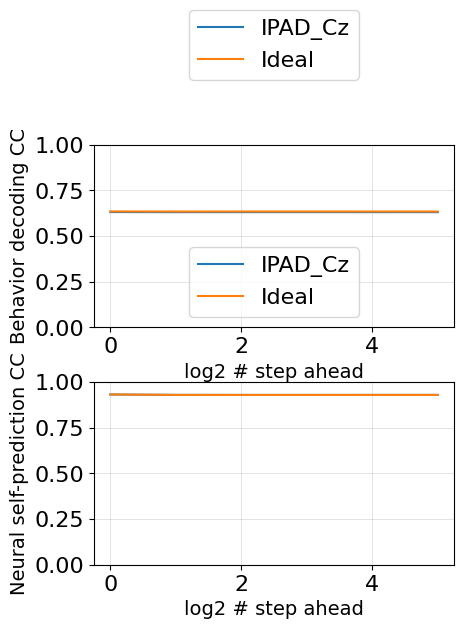

In [11]:
# Plot forecasting
plt.figure(figsize=(6,7))
ax = plt.axis()
xlabel = 'log2 # step ahead'
plt.subplot(2,1,1)
plt.plot(np.log2(np.array(steps_ahead)), zCCNonLinF, label='BRAID_Cz')
plt.plot(np.log2(np.array(steps_ahead)), zCCIdeal, label='Ideal')
plt.legend(bbox_to_anchor=(0.5, 1.8), loc='upper center')
plt.xlabel(xlabel)
plt.ylabel('Behavior decoding CC')
plt.grid(linewidth=0.5, alpha=0.5)
plt.ylim([0,1])

plt.subplot(2,1,2)
plt.plot(np.log2(np.array(steps_ahead)), yCCNonLinF, label='BRAID_Cz')
plt.plot(np.log2(np.array(steps_ahead)), yCCIdeal, label='Ideal')
plt.legend(bbox_to_anchor=(0.5, 1.8), loc='upper center')
plt.xlabel(xlabel)
plt.ylabel('Neural self-prediction CC')
plt.grid(linewidth=0.5, alpha=0.5)
plt.subplots_adjust(left=0.2,bottom=0.1, right=0.8, top=0.7, wspace=0.1, hspace=0.3)
plt.ylim([0,1])

Calculating normalized eigenvalue error

In [ ]:
# Get intrinsic behavioral relevant dynamics eigenvalues and calculated normalized eigenvalue error:
Afw_true = trueModel.A
Afw = idSysF.model1.rnn.cell.Afw.get_weights()[0].T
idZEigs = np.linalg.eig(Afw[list(idSysF.zDims-1)][:, list(idSysF.zDims-1)])[0]
trueZEigs = np.linalg.eig(Afw_true)[0]
zEigErr_Afw = computeEigIdError(trueZEigs, [idZEigs], 'NFN')[0]
